# ADS599 Capstone : GenoDetect Data Preparation

## Importing Libraries, Function Definitions

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, zscore
from google.colab import drive
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import random


In [72]:
#Skew & outlier test function, formatting adjusted with assistance from ChatGPT for readability (OpenAI, 2023)
def skew_and_outlier_test(df, skew_threshold=1.0, zscore_threshold=3.0):
    # Identify and convert numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    skewed_columns = []
    # Identify skewed columns
    for column in numeric_columns:
        column_skewness = skew(df[column].dropna(), nan_policy='omit')
        if abs(column_skewness) > skew_threshold:
            skewed_columns.append(column)
            # Outlier test using Z-score
            column_data = df[column].dropna()
            if len(column_data) > 0:
                z_scores = zscore(column_data)
                outlier_count = np.sum(abs(z_scores) > zscore_threshold)
                print(f"Column '{column}': Number of outliers - {outlier_count}")
    num_skewed_columns = len(skewed_columns)
    num_rows = (num_skewed_columns // 3) + (1 if num_skewed_columns % 3 > 0 else 0)
    num_cols = min(3, num_skewed_columns)

    if skewed_columns:
        plt.figure(figsize=(12, 4 * num_rows))
        for i, column in enumerate(skewed_columns, 1):
            plt.subplot(num_rows, num_cols, i)
            df[column].value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.7)
            plt.title(f'Binary Column: {column}')
            plt.xlabel('Values')
            plt.ylabel('Frequency')
            column_skewness = skew(df[column].dropna(), nan_policy='omit')
            plt.text(0.95, 0.95, f'{column}\nSkew: {column_skewness:.2f}', transform=plt.gca().transAxes,
                     fontsize=8, verticalalignment='top', horizontalalignment='right')
            print(f"Column '{column}': Skew - {column_skewness}")
        plt.tight_layout()
        plt.show()

    return skewed_columns


In [73]:
#Label encoder, formatting adjusted with assistance from ChatGPT for readability (OpenAI, 2023)
def label_encode_columns(df, columns_to_encode):
    encode_func = LabelEncoder()
    for column in columns_to_encode:
        if df[column].dtype == 'object':
            df[column] = encode_func.fit_transform(df[column].fillna('NaN'))
        else:
            df[column] = encode_func.fit_transform(df[column])
    return df.astype("float32")

## Load in Data & Initial View

In [74]:
# Load in data
drive.mount('/content/drive')
test=pd.read_csv('/content/drive/MyDrive/capstone/test.csv')
train=pd.read_csv('/content/drive/MyDrive/capstone/train.csv')
test.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5
0,PID0x4175,6,No,Yes,No,No,4.981655,Charles,NaN,Kore,...,-99,2,Multiple,-99.000000,slightly abnormal,True,True,True,True,True
1,PID0x21f5,10,Yes,No,NaN,Yes,5.118890,Catherine,NaN,Homero,...,Yes,-99,Multiple,8.179584,normal,False,False,False,True,False
2,PID0x49b8,5,No,NaN,No,No,4.876204,James,NaN,Danield,...,No,0,Singular,-99.000000,slightly abnormal,False,False,True,True,False
3,PID0x2d97,13,No,Yes,Yes,No,4.687767,Brian,NaN,Orville,...,Yes,-99,Singular,6.884071,normal,True,False,True,False,True
4,PID0x58da,5,No,NaN,NaN,Yes,5.152362,Gary,NaN,Issiah,...,No,-99,Multiple,6.195178,normal,True,True,True,True,False


In [75]:
test.shape

(9465, 43)

In [76]:
train.head()

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


## Begin Preparation

In [77]:
#Renaming columns
new_column_names = ["Patient_Id",
                    "Patient_Age",
                    "Inherited_from_mother",
                    "Inherited_from_father",
                    "Maternal_Gene",
                    "Paternal_Gene",
                    "BCC_mcL",
                    "Patient_First_Name",
                    "Family_Name",
                    "Father_Name",
                    "Mother_Age",
                    "Father_Age",
                    "Institute_Name",
                    "Location_of_Institute",
                    "Status",
                    "Resp_Rate_BreathsPerMin",
                    "Heart_Rate_RatesPerMin",
                    "Test_1", "Test_2", "Test_3", "Test_4", "Test_5",
                    "Parental_Consent",
                    "Follow_Up",
                    "Gender",
                    "Birth_Asphyxia",
                    "Autopsy_BD",
                    "Place_Birth",
                    "Folic_Acid_Details",
                    "Serious_Maternal_Illness",
                    "Radiation_Exposure",
                    "Substance_Abuse",
                    "IVF_ART",
                    "History_Previous_Anomalies_Pregnancies",
                    "Previous_Abortion",
                    "Birth_Defects",
                    "WBC",
                    "Blood_Test",
                    "Symptom_1", "Symptom_2", "Symptom_3", "Symptom_4", "Symptom_5",
                    "Genetic_Disorder",
                    "Disorder_Subclass"]


# Rename columns using the list
train.columns = new_column_names

In [78]:
# Shape, Info to assure renaming
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Patient_Id                              22083 non-null  object 
 1   Patient_Age                             20656 non-null  float64
 2   Inherited_from_mother                   22083 non-null  object 
 3   Inherited_from_father                   21777 non-null  object 
 4   Maternal_Gene                           19273 non-null  object 
 5   Paternal_Gene                           22083 non-null  object 
 6   BCC_mcL                                 22083 non-null  float64
 7   Patient_First_Name                      22083 non-null  object 
 8   Family_Name                             12392 non-null  object 
 9   Father_Name                             22083 non-null  object 
 10  Mother_Age                              16047 non-null  fl

In [79]:
#Get total NA counts
print(train.isna().sum())

Patient_Id                                   0
Patient_Age                               1427
Inherited_from_mother                        0
Inherited_from_father                      306
Maternal_Gene                             2810
Paternal_Gene                                0
BCC_mcL                                      0
Patient_First_Name                           0
Family_Name                               9691
Father_Name                                  0
Mother_Age                                6036
Father_Age                                5986
Institute_Name                            5106
Location_of_Institute                        0
Status                                       0
Resp_Rate_BreathsPerMin                   2149
Heart_Rate_RatesPerMin                    2113
Test_1                                    2127
Test_2                                    2152
Test_3                                    2147
Test_4                                    2140
Test_5       

In [80]:
#Identify Numeric NAN
numeric_columns = train.select_dtypes(include=[np.number]).columns
numeric_data = train[numeric_columns]
print("Numeric NAN Before Fill:\n")
print(numeric_data.isna().sum())

Numeric NAN Before Fill:

Patient_Age          1427
BCC_mcL                 0
Mother_Age           6036
Father_Age           5986
Test_1               2127
Test_2               2152
Test_3               2147
Test_4               2140
Test_5               2170
Previous_Abortion    2162
WBC                  2148
Symptom_1            2155
Symptom_2            2222
Symptom_3            2101
Symptom_4            2113
Symptom_5            2153
dtype: int64


In [81]:
#Fill numeric NA with median value
warnings.filterwarnings("ignore")
medians = numeric_data.median()
numeric_data.fillna(medians, inplace=True)
print("Numeric NAN After Median Fill:\n")
print(numeric_data.isna().sum())

Numeric NAN After Median Fill:

Patient_Age          0
BCC_mcL              0
Mother_Age           0
Father_Age           0
Test_1               0
Test_2               0
Test_3               0
Test_4               0
Test_5               0
Previous_Abortion    0
WBC                  0
Symptom_1            0
Symptom_2            0
Symptom_3            0
Symptom_4            0
Symptom_5            0
dtype: int64


In [82]:
#Assure numeric NA are filled
train_numfill = train
train_numfill[numeric_columns] = numeric_data
print(train_numfill.isna().sum())

Patient_Id                                   0
Patient_Age                                  0
Inherited_from_mother                        0
Inherited_from_father                      306
Maternal_Gene                             2810
Paternal_Gene                                0
BCC_mcL                                      0
Patient_First_Name                           0
Family_Name                               9691
Father_Name                                  0
Mother_Age                                   0
Father_Age                                   0
Institute_Name                            5106
Location_of_Institute                        0
Status                                       0
Resp_Rate_BreathsPerMin                   2149
Heart_Rate_RatesPerMin                    2113
Test_1                                       0
Test_2                                       0
Test_3                                       0
Test_4                                       0
Test_5       

In [83]:
#Yes/No Columns to Binary
# Only doing Yes/No here - some other columns have other responses beyond this.
columns_to_convert = ['Inherited_from_mother', 'Inherited_from_father', 'Maternal_Gene', 'Paternal_Gene', 'Serious_Maternal_Illness', 'IVF_ART', 'History_Previous_Anomalies_Pregnancies']

# Mapping 'yes' to 1 and 'no' to 0 for specified columns
for column in columns_to_convert:
    train_numfill[column] = train_numfill[column].map({'Yes': 1, 'No': 0})

In [84]:
train_numfill.head()

,Patient_Id,Patient_Age,Inherited_from_mother,Inherited_from_father,Maternal_Gene,Paternal_Gene,BCC_mcL,Patient_First_Name,Family_Name,Father_Name,...,Birth_Defects,WBC,Blood_Test,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Genetic_Disorder,Disorder_Subclass
0,PID0x6418,2.0,1,0.0,1.0,0,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,1,1.0,0.0,0,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,1.0,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,1,0.0,0.0,0,4.893297,Kimberly,NaN,Nashon,...,Singular,7.477132,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,1,0.0,1.0,0,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,1,0.0,NaN,1,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,0.0,Multifactorial genetic inheritance disorders,Cancer


In [85]:
print("INFO:\n")
print(train_numfill.info())

INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Patient_Id                              22083 non-null  object 
 1   Patient_Age                             22083 non-null  float64
 2   Inherited_from_mother                   22083 non-null  int64  
 3   Inherited_from_father                   21777 non-null  float64
 4   Maternal_Gene                           19273 non-null  float64
 5   Paternal_Gene                           22083 non-null  int64  
 6   BCC_mcL                                 22083 non-null  float64
 7   Patient_First_Name                      22083 non-null  object 
 8   Family_Name                             12392 non-null  object 
 9   Father_Name                             22083 non-null  object 
 10  Mother_Age                              22083 non-n

In [86]:
# One-hot encode disorders to look for correlations between disorder and data
train_numfill['Disorder+Subclass'] = train['Genetic_Disorder'] + ' - ' + train['Disorder_Subclass']
onehot = pd.get_dummies(train_numfill['Disorder+Subclass'])
train_numfill.drop(['Genetic_Disorder', 'Disorder_Subclass','Disorder+Subclass'], axis=1, inplace=True)
train_numfill = train_numfill.join(onehot)
train_numfill.head()

,Patient_Id,Patient_Age,Inherited_from_mother,Inherited_from_father,Maternal_Gene,Paternal_Gene,BCC_mcL,Patient_First_Name,Family_Name,Father_Name,...,Symptom_5,Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy,Mitochondrial genetic inheritance disorders - Leigh syndrome,Mitochondrial genetic inheritance disorders - Mitochondrial myopathy,Multifactorial genetic inheritance disorders - Alzheimer's,Multifactorial genetic inheritance disorders - Cancer,Multifactorial genetic inheritance disorders - Diabetes,Single-gene inheritance diseases - Cystic fibrosis,Single-gene inheritance diseases - Hemochromatosis,Single-gene inheritance diseases - Tay-Sachs
0,PID0x6418,2.0,1,0.0,1.0,0,4.760603,Richard,NaN,Larre,...,1.0,1,0,0,0,0,0,0,0,0
1,PID0x25d5,4.0,1,1.0,0.0,0,4.910669,Mike,NaN,Brycen,...,0.0,0,0,0,0,0,0,0,0,0
2,PID0x4a82,6.0,1,0.0,0.0,0,4.893297,Kimberly,NaN,Nashon,...,1.0,0,0,0,0,0,1,0,0,0
3,PID0x4ac8,12.0,1,0.0,1.0,0,4.705280,Jeffery,Hoelscher,Aayaan,...,0.0,0,1,0,0,0,0,0,0,0
4,PID0x1bf7,11.0,1,0.0,NaN,1,4.720703,Johanna,Stutzman,Suave,...,0.0,0,0,0,0,1,0,0,0,0


In [87]:
train_numfill.head()

,Patient_Id,Patient_Age,Inherited_from_mother,Inherited_from_father,Maternal_Gene,Paternal_Gene,BCC_mcL,Patient_First_Name,Family_Name,Father_Name,...,Symptom_5,Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy,Mitochondrial genetic inheritance disorders - Leigh syndrome,Mitochondrial genetic inheritance disorders - Mitochondrial myopathy,Multifactorial genetic inheritance disorders - Alzheimer's,Multifactorial genetic inheritance disorders - Cancer,Multifactorial genetic inheritance disorders - Diabetes,Single-gene inheritance diseases - Cystic fibrosis,Single-gene inheritance diseases - Hemochromatosis,Single-gene inheritance diseases - Tay-Sachs
0,PID0x6418,2.0,1,0.0,1.0,0,4.760603,Richard,NaN,Larre,...,1.0,1,0,0,0,0,0,0,0,0
1,PID0x25d5,4.0,1,1.0,0.0,0,4.910669,Mike,NaN,Brycen,...,0.0,0,0,0,0,0,0,0,0,0
2,PID0x4a82,6.0,1,0.0,0.0,0,4.893297,Kimberly,NaN,Nashon,...,1.0,0,0,0,0,0,1,0,0,0
3,PID0x4ac8,12.0,1,0.0,1.0,0,4.705280,Jeffery,Hoelscher,Aayaan,...,0.0,0,1,0,0,0,0,0,0,0
4,PID0x1bf7,11.0,1,0.0,NaN,1,4.720703,Johanna,Stutzman,Suave,...,0.0,0,0,0,0,1,0,0,0,0


## Feature Engineering

In [88]:
columns_to_drop = [
    "Patient_Id",
    "Patient_First_Name",
    "Family_Name",
    "Father_Name",
    "Institute_Name",
    "Location_of_Institute","Parental_Consent", "Place_Birth",
]

train_2 = train_numfill.drop(columns=columns_to_drop)
train_2.head()

,Patient_Age,Inherited_from_mother,Inherited_from_father,Maternal_Gene,Paternal_Gene,BCC_mcL,Mother_Age,Father_Age,Status,Resp_Rate_BreathsPerMin,...,Symptom_5,Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy,Mitochondrial genetic inheritance disorders - Leigh syndrome,Mitochondrial genetic inheritance disorders - Mitochondrial myopathy,Multifactorial genetic inheritance disorders - Alzheimer's,Multifactorial genetic inheritance disorders - Cancer,Multifactorial genetic inheritance disorders - Diabetes,Single-gene inheritance diseases - Cystic fibrosis,Single-gene inheritance diseases - Hemochromatosis,Single-gene inheritance diseases - Tay-Sachs
0,2.0,1,0.0,1.0,0,4.760603,35.0,42.0,Alive,Normal (30-60),...,1.0,1,0,0,0,0,0,0,0,0
1,4.0,1,1.0,0.0,0,4.910669,35.0,23.0,Deceased,Tachypnea,...,0.0,0,0,0,0,0,0,0,0,0
2,6.0,1,0.0,0.0,0,4.893297,41.0,22.0,Alive,Normal (30-60),...,1.0,0,0,0,0,0,1,0,0,0
3,12.0,1,0.0,1.0,0,4.705280,21.0,42.0,Deceased,Tachypnea,...,0.0,0,1,0,0,0,0,0,0,0
4,11.0,1,0.0,NaN,1,4.720703,32.0,42.0,Alive,Tachypnea,...,0.0,0,0,0,0,1,0,0,0,0


In [89]:
genetic_disorder_columns = [
    "Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy",
    "Mitochondrial genetic inheritance disorders - Leigh syndrome",
    "Mitochondrial genetic inheritance disorders - Mitochondrial myopathy",
    "Multifactorial genetic inheritance disorders - Alzheimer's",
    "Multifactorial genetic inheritance disorders - Cancer",
    "Multifactorial genetic inheritance disorders - Diabetes",
    "Single-gene inheritance diseases - Cystic fibrosis",
    "Single-gene inheritance diseases - Hemochromatosis",
    "Single-gene inheritance diseases - Tay-Sachs",
]

# Create the new "Genetic_Disorder" column
train_2['Genetic_Disorder'] = train_2[genetic_disorder_columns].any(axis=1).astype(int)
train_2.head()

,Patient_Age,Inherited_from_mother,Inherited_from_father,Maternal_Gene,Paternal_Gene,BCC_mcL,Mother_Age,Father_Age,Status,Resp_Rate_BreathsPerMin,...,Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy,Mitochondrial genetic inheritance disorders - Leigh syndrome,Mitochondrial genetic inheritance disorders - Mitochondrial myopathy,Multifactorial genetic inheritance disorders - Alzheimer's,Multifactorial genetic inheritance disorders - Cancer,Multifactorial genetic inheritance disorders - Diabetes,Single-gene inheritance diseases - Cystic fibrosis,Single-gene inheritance diseases - Hemochromatosis,Single-gene inheritance diseases - Tay-Sachs,Genetic_Disorder
0,2.0,1,0.0,1.0,0,4.760603,35.0,42.0,Alive,Normal (30-60),...,1,0,0,0,0,0,0,0,0,1
1,4.0,1,1.0,0.0,0,4.910669,35.0,23.0,Deceased,Tachypnea,...,0,0,0,0,0,0,0,0,0,0
2,6.0,1,0.0,0.0,0,4.893297,41.0,22.0,Alive,Normal (30-60),...,0,0,0,0,0,1,0,0,0,1
3,12.0,1,0.0,1.0,0,4.705280,21.0,42.0,Deceased,Tachypnea,...,0,1,0,0,0,0,0,0,0,1
4,11.0,1,0.0,NaN,1,4.720703,32.0,42.0,Alive,Tachypnea,...,0,0,0,0,1,0,0,0,0,1


## Dummies for Cat Columms

In [90]:
train_2.head(5)

,Patient_Age,Inherited_from_mother,Inherited_from_father,Maternal_Gene,Paternal_Gene,BCC_mcL,Mother_Age,Father_Age,Status,Resp_Rate_BreathsPerMin,...,Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy,Mitochondrial genetic inheritance disorders - Leigh syndrome,Mitochondrial genetic inheritance disorders - Mitochondrial myopathy,Multifactorial genetic inheritance disorders - Alzheimer's,Multifactorial genetic inheritance disorders - Cancer,Multifactorial genetic inheritance disorders - Diabetes,Single-gene inheritance diseases - Cystic fibrosis,Single-gene inheritance diseases - Hemochromatosis,Single-gene inheritance diseases - Tay-Sachs,Genetic_Disorder
0,2.0,1,0.0,1.0,0,4.760603,35.0,42.0,Alive,Normal (30-60),...,1,0,0,0,0,0,0,0,0,1
1,4.0,1,1.0,0.0,0,4.910669,35.0,23.0,Deceased,Tachypnea,...,0,0,0,0,0,0,0,0,0,0
2,6.0,1,0.0,0.0,0,4.893297,41.0,22.0,Alive,Normal (30-60),...,0,0,0,0,0,1,0,0,0,1
3,12.0,1,0.0,1.0,0,4.705280,21.0,42.0,Deceased,Tachypnea,...,0,1,0,0,0,0,0,0,0,1
4,11.0,1,0.0,NaN,1,4.720703,32.0,42.0,Alive,Tachypnea,...,0,0,0,0,1,0,0,0,0,1


In [91]:
print(train_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Patient_Age                                                                        22083 non-null  float64
 1   Inherited_from_mother                                                              22083 non-null  int64  
 2   Inherited_from_father                                                              21777 non-null  float64
 3   Maternal_Gene                                                                      19273 non-null  float64
 4   Paternal_Gene                                                                      22083 non-null  int64  
 5   BCC_mcL                                                                            22083 non-null  flo

In [92]:
columns_to_encode = [
    'Status', 'Resp_Rate_BreathsPerMin', 'Heart_Rate_RatesPerMin', 'Follow_Up',
    'Gender', 'Birth_Asphyxia', 'Autopsy_BD', 'Folic_Acid_Details', 'Radiation_Exposure',
    'Substance_Abuse', 'Birth_Defects', 'Blood_Test', 'Maternal_Gene', 'Inherited_from_father',
    'Serious_Maternal_Illness', 'IVF_ART', 'History_Previous_Anomalies_Pregnancies'
]

Encode_Data = label_encode_columns(train_2, columns_to_encode)


In [93]:
Encode_Data.head()

,Patient_Age,Inherited_from_mother,Inherited_from_father,Maternal_Gene,Paternal_Gene,BCC_mcL,Mother_Age,Father_Age,Status,Resp_Rate_BreathsPerMin,...,Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy,Mitochondrial genetic inheritance disorders - Leigh syndrome,Mitochondrial genetic inheritance disorders - Mitochondrial myopathy,Multifactorial genetic inheritance disorders - Alzheimer's,Multifactorial genetic inheritance disorders - Cancer,Multifactorial genetic inheritance disorders - Diabetes,Single-gene inheritance diseases - Cystic fibrosis,Single-gene inheritance diseases - Hemochromatosis,Single-gene inheritance diseases - Tay-Sachs,Genetic_Disorder
0,2.0,1.0,0.0,1.0,0.0,4.760603,35.0,42.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4.0,1.0,1.0,0.0,0.0,4.910669,35.0,23.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.0,1.0,0.0,0.0,0.0,4.893297,41.0,22.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,12.0,1.0,0.0,1.0,0.0,4.705280,21.0,42.0,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,11.0,1.0,0.0,2.0,1.0,4.720703,32.0,42.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [94]:
print(Encode_Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 45 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Patient_Age                                                                        22083 non-null  float32
 1   Inherited_from_mother                                                              22083 non-null  float32
 2   Inherited_from_father                                                              22083 non-null  float32
 3   Maternal_Gene                                                                      22083 non-null  float32
 4   Paternal_Gene                                                                      22083 non-null  float32
 5   BCC_mcL                                                                            22083 non-null  flo

In [95]:
train_3 = Encode_Data.copy()

## Identifying Skew and Outliers

Column 'Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy': Number of outliers - 587
Column 'Mitochondrial genetic inheritance disorders - Leigh syndrome': Number of outliers - 0
Column 'Mitochondrial genetic inheritance disorders - Mitochondrial myopathy': Number of outliers - 0
Column 'Multifactorial genetic inheritance disorders - Alzheimer's': Number of outliers - 133
Column 'Multifactorial genetic inheritance disorders - Cancer': Number of outliers - 91
Column 'Multifactorial genetic inheritance disorders - Diabetes': Number of outliers - 1653
Column 'Single-gene inheritance diseases - Cystic fibrosis': Number of outliers - 0
Column 'Single-gene inheritance diseases - Hemochromatosis': Number of outliers - 1228
Column 'Single-gene inheritance diseases - Tay-Sachs': Number of outliers - 0
Column 'Genetic_Disorder': Number of outliers - 0
Column 'Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy': Skew - 5.8862053392219

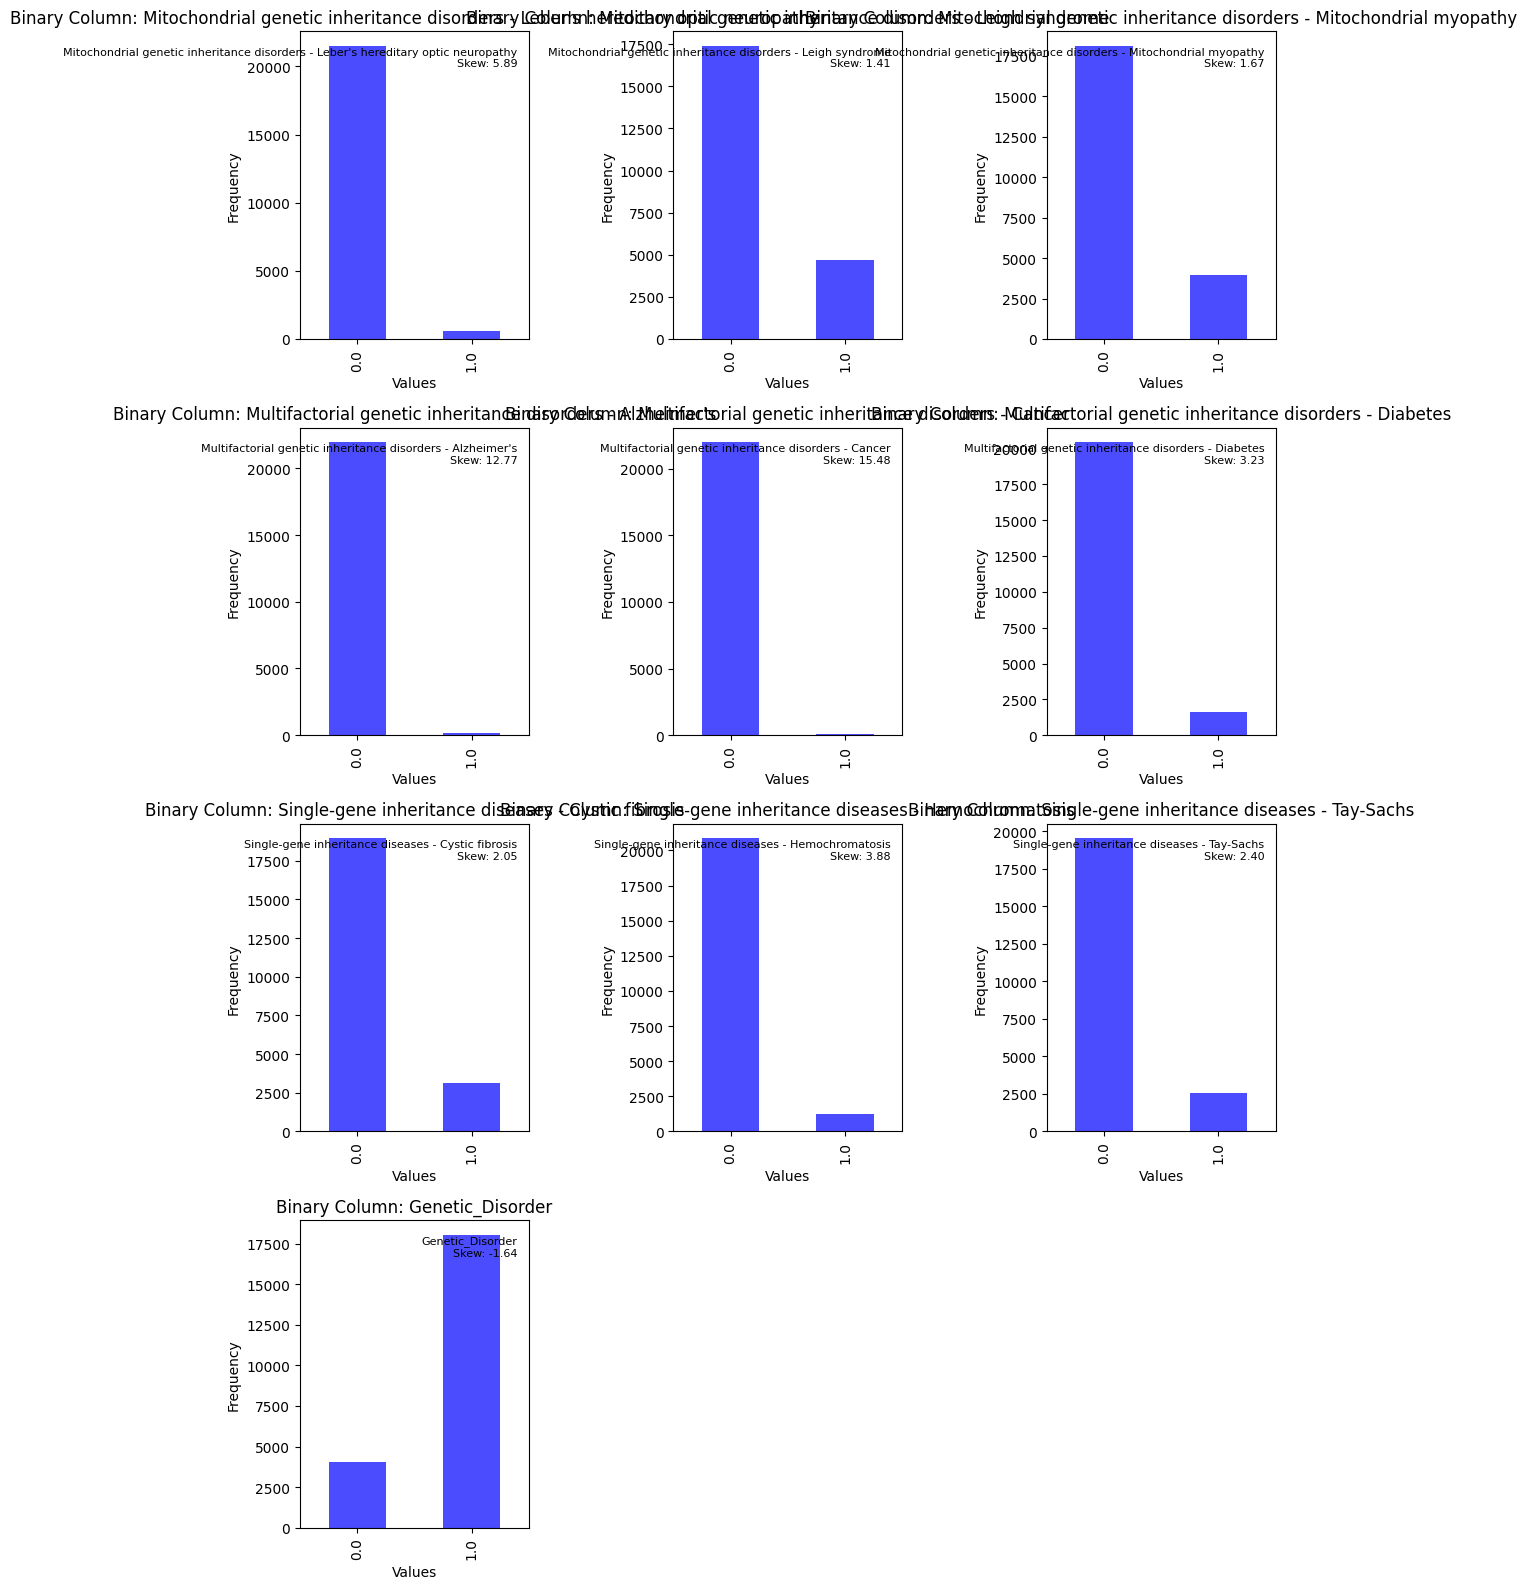

Skewed Columns in 'train_3': ["Mitochondrial genetic inheritance disorders - Leber's hereditary optic neuropathy", 'Mitochondrial genetic inheritance disorders - Leigh syndrome', 'Mitochondrial genetic inheritance disorders - Mitochondrial myopathy', "Multifactorial genetic inheritance disorders - Alzheimer's", 'Multifactorial genetic inheritance disorders - Cancer', 'Multifactorial genetic inheritance disorders - Diabetes', 'Single-gene inheritance diseases - Cystic fibrosis', 'Single-gene inheritance diseases - Hemochromatosis', 'Single-gene inheritance diseases - Tay-Sachs', 'Genetic_Disorder']


In [96]:
skewed_columns_train = skew_and_outlier_test(train_3)

print("Skewed Columns in 'train_3':", skewed_columns_train)

## Train, Test, Validation Splits

In [97]:
##Remove Target Variable - Genetic Disorder
X = train_3.iloc[:, 0:30]
y = train_3['Genetic_Disorder']

X.head()

,Patient_Age,Inherited_from_mother,Inherited_from_father,Maternal_Gene,Paternal_Gene,BCC_mcL,Mother_Age,Father_Age,Status,Resp_Rate_BreathsPerMin,...,Folic_Acid_Details,Serious_Maternal_Illness,Radiation_Exposure,Substance_Abuse,IVF_ART,History_Previous_Anomalies_Pregnancies,Previous_Abortion,Birth_Defects,WBC,Blood_Test
0,2.0,1.0,0.0,1.0,0.0,4.760603,35.0,42.0,0.0,1.0,...,1.0,2.0,2.0,2.0,0.0,1.0,2.0,1.0,9.857562,0.0
1,4.0,1.0,1.0,0.0,0.0,4.910669,35.0,23.0,1.0,2.0,...,2.0,1.0,3.0,3.0,0.0,1.0,2.0,0.0,5.522560,3.0
2,6.0,1.0,0.0,0.0,0.0,4.893297,41.0,22.0,0.0,1.0,...,2.0,0.0,4.0,1.0,1.0,1.0,4.0,2.0,7.477132,3.0
3,12.0,1.0,0.0,1.0,0.0,4.705280,21.0,42.0,1.0,2.0,...,1.0,1.0,0.0,3.0,2.0,1.0,1.0,2.0,7.919321,2.0
4,11.0,1.0,0.0,2.0,1.0,4.720703,32.0,42.0,0.0,2.0,...,1.0,1.0,0.0,3.0,1.0,0.0,4.0,0.0,4.098210,0.0


In [98]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# Assuming X and y are pandas DataFrames or Series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# Convert the arrays to pandas DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)  # Assuming X has column names
y_train = pd.Series(y_train)

# Similarly, for validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))
X_val = pd.DataFrame(X_val, columns=X.columns)
y_val = pd.Series(y_val)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_test = pd.Series(y_test)


In [99]:
print('The train set has', X_train.shape[0], 'rows and', X_train.shape[1],
      'columns.')
print('The test set has', X_test.shape[0], 'rows and', X_test.shape[1],
      'columns.')
print('The validation set has', X_val.shape[0], 'rows and', X_val.shape[1],
      'columns.')

The train set has 17666 rows and 30 columns.
The test set has 2209 rows and 30 columns.
The validation set has 2208 rows and 30 columns.


## Scaling the Data

In [100]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert NumPy arrays back to pandas DataFrames
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [101]:
X_train.head()

,Patient_Age,Inherited_from_mother,Inherited_from_father,Maternal_Gene,Paternal_Gene,BCC_mcL,Mother_Age,Father_Age,Status,Resp_Rate_BreathsPerMin,...,Folic_Acid_Details,Serious_Maternal_Illness,Radiation_Exposure,Substance_Abuse,IVF_ART,History_Previous_Anomalies_Pregnancies,Previous_Abortion,Birth_Defects,WBC,Blood_Test
0,0.242395,0.826024,1.112943,0.392070,-0.876768,0.494091,-0.436374,-0.899150,-0.995482,-0.542696,...,0.979733,0.539294,-1.473081,-1.449841,2.084338,0.537674,-0.001222,-1.054486,0.557185,1.333911
1,0.002754,0.826024,-0.804293,1.885775,-0.876768,-0.398016,-1.863543,0.538676,-0.995482,0.998171,...,0.979733,-0.996354,1.290006,-1.449841,0.545153,0.537674,-0.001222,-1.054486,-0.369450,-0.973129
2,1.440600,-1.210618,-0.804293,0.392070,1.140552,1.363146,0.039350,0.538676,1.004539,-0.542696,...,0.979733,2.074942,-1.473081,-0.763922,0.545153,0.537674,-1.489965,-1.054486,-0.647328,-0.204115
3,0.961318,-1.210618,-0.804293,0.392070,-0.876768,0.135568,-1.506751,-0.000509,1.004539,-2.083563,...,-0.564242,0.539294,-0.091537,1.293834,-0.994031,0.537674,-0.001222,1.050554,-1.630781,-0.973129
4,1.440600,-1.210618,-0.804293,-1.101635,-0.876768,-0.256399,-1.031028,1.976501,-0.995482,0.998171,...,-2.108218,0.539294,-0.091537,0.607915,0.545153,0.537674,-0.745594,1.050554,0.699477,0.564898


## Save for Future Use

In [103]:
# Save scaled DataFrames to CSV
folder_path = '/content/drive/MyDrive/capstone/'
X_train.to_csv(folder_path + 'X_train_scaled.csv', index=False)
X_val.to_csv(folder_path + 'X_val_scaled.csv', index=False)
X_test.to_csv(folder_path + 'X_test_scaled.csv', index=False)